# MNIST Hand Written Digits

In this problem, we will teach a simple model to learn to identify hand written digits.

Firstly, install the python package for reading the mnist data set by running the command:
```python
pip install python-mnist
```

Then, get the unprocessed data from Yan Lecunn's webpage or directly from here:
https://www.dropbox.com/s/7rb011wzqu3rbij/mnist.zip?dl=0

Unzip the file to the folder of your choice. Note that the address to the containing unzipped files should be fed into the `MNIST('folder_address')`.

The easiest way to load the data after downloading it is to use a python library created for loading MNIST data set. Writing down the loading function from scratch is not a hard task but it is not the focus of this tutorial and we simplify this task by installing the MNIST library:
```
pip install python-mnist
```
After that, you can load the training and test data sets.

# Step 1: Preprocessing the Data

Firstly, we need to preprocess the data to a form appropriate for our model. We will use a simple **logistic regression model** as our classifier. As we will see later, a logistic regression model can be thought of as a simple block that we can create Neural Networks out of it. Hence, getting familiar with this model is important. Also, simplicity of this model makes it a good candidate for our first model.

To simplify the problem, we will focus on just two classes in the mnist dataset: 1s and 5s. Remember that the in case of the logistic regression, the true labels ($y^i$s) should be 1 for positive samples (meaning that the image is the digit 1) and zero for negative examples (meaning that the image is the digit 5 in our problem).

In [6]:
import numpy as np
from mnist import MNIST
import matplotlib.pylab as plt
%matplotlib inline

In [7]:
# for reproducibility of the results
np.random.seed(1)

In [8]:
# read the raw images and labels
mndata = MNIST('mnist')
training_images, training_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

Let us get a sense of how the data looks like.

In [9]:
# number of samples
print( 'Number of samples is '+ str(len(training_images)) )
print( 'Number of test images is '+ str(len(test_images)) )

Number of samples is 60000
Number of test images is 10000


Remember that the images are presented as flatten vectors of size 784 which is made out of 28 by 28 images.

In [10]:
# one sample image
#training_images[0]

In [11]:
# convert the lists to numpy array for easier manipulation
training_images = np.array([np.array(item) for item in training_images])
training_labels = np.array(training_labels)
test_images = np.array([np.array(item) for item in test_images])
test_labels = np.array(test_labels)

We will check how many 1s and 5s we have in the data set. We will focus on these two digits for now.

In [12]:
num_5s = len(np.where(training_labels==5)[0])
print(num_5s)
num_1s = len(np.where(training_labels==1)[0])
print(num_1s)

5421
6742


Note that we have to reshape the image vectors to `(28,28)` because in the raw data they are flattened to flat 748d vectors. Use the `reshape` function from numpy to reshape the picked example `training_images[k]`.

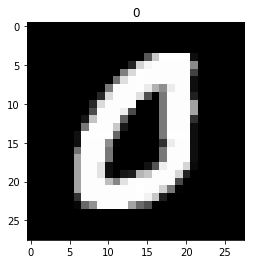

In [13]:
# pick a random item from the training set and visualize it
k = np.random.choice(len(training_images))
# reshape the vector to its image dimensions 
example_image = training_images[k].reshape((28,28))
example_label = training_labels[k]

plt.imshow(example_image, cmap='gray')
plt.title(example_label)
plt.show()

We extract two features from each image. These two features are manually tailored for distinguishing between 1s and 5s. Later in the course, we will see how **Deep Learning methods automatically create such features**.

Our features are:
1. Average intensity. In general, 5s have more strokes on the paper which implies higher average values.
2. Horizontal symmetry. In general, 1s are more symmetrical compared to 5s.

We expect these two features to get us some level of separation between 1s and 5s. If the level of separation is desent, we should be able to teach a logistic regression to learn the linear patterns.

Here you will implement a function that gets a flat vector `X` and calculates its average intensity. You can use `np.mean()` function here.

**Important Note 1.** In numpy, there are arrays of dimension `(n,)`. These arrays (most of the times) behaves like a `(n,1)` dimensional tensor. But in some specific cases, their behaviour is strangely different. Therefore, it is a good practice to always, work with `(1,n)` or `(n,1)` shaped tensors. If the result of your calculations produces a `(n,)` array, just reshape it to the appropriate shape.

**Important Note 2.** We set these conventions to use throughout the course:
1. Each sample is presented by a column vector (not a row vector) so it will be of shape `(d,1)`.
2. The whole data set is made of putting the column vectors (samples' input) to a matrix. Hence it is of the shape `(d,M)` where d is the number of input dimensions/features and M is the number of samples. If you want to read the shape of an array use `X.shape` and do not trust the way the array is printed.

**Important Note 3.** The main data type that we work with in this course are arrays of different dimensions. In our convention, if the array contains numbers and is of the form $(n,1)$ we call it a vector, if the array contains numbers and is of the form $(n,m)$ we call it a matrix and if the array contains numbers and is of the form $(n_1,n_2,...,n_k)$ we call if a tensor.

In [14]:
def mean_intensity(X):
    ave = np.mean(X,axis=0)
    # reshape to the appripriate dimensions
    ave = ave.reshape((ave.shape[0],1)).T
    return ave

Next we check that the function creates a vectorized mean. Lets consider X to a be a tensor made out of three 3d vectors that we can find the mean of each vector easily. When fed to our function, the result should be a vector of means.

In [15]:
X = np.array([[1,1,1],[2,2,2],[3,3,3],[4,4,4]]).T
X.shape

(3, 4)

In [16]:
print(mean_intensity(X))
mean_intensity(X).shape

[[ 1.  2.  3.  4.]]


(1, 4)

next, we will implement a function that gets a flat vector `X`, reshape it to a square matrix and calculates its horizontal symmetric level by subtracting the image from its flipped version. Make sure you understand how it works.

In [17]:
def symmetry(X):
    # find and reshape to the original dimensions of the image
    dim = X.shape[0]
    sqr_mat = X.reshape((int(np.sqrt(dim)),int(np.sqrt(dim)),X.shape[1]))
    # flip the images horizontally
    flipped = np.flip(sqr_mat,axis=1)
    # difference of the image and its flipped
    diff = sqr_mat - flipped
    abs_diff = np.absolute(diff)
    # flatten the images back to vectors
    flatten = abs_diff.reshape(X.shape)
    # find the avrage antisymmetry and subtract from 1 for symmetry
    ave = 1 - np.mean(flatten,axis=0)
    # reshape to the appropriate shape
    ave = ave.reshape((1,ave.shape[0]))
    return ave

Let us check that the function creates a vectorized symmetry result. Lets consider X to a be a tensor made out of 3 4d vectors that need to be converted to $2\times 2$ matrices and then we find the symmetry of each vector and double check the answer.

In [18]:
X = np.array([[1,1,0,0],[0,1,1,0],[0,0,0,1]]).T
print(X.shape)

print(symmetry(X))
print(symmetry(X).shape)

(4, 3)
[[ 1.   0.   0.5]]
(1, 3)


The problem of identifying 1s and 5s is a very easy problem and we expect that only a portion of 1s and 5s would be enough for it. Hence, we use only 500 samples from each class. Here you will pick 500 images with their labels from the training data. The helpful functions are: `np.random.choice()`and `np.where()`. For `np.random.choise()` function, use the option `replace=False` to avoid picking the same item.

In [19]:
# finding the index of all 1s and 5s
index_1s = np.where(training_labels==1)[0]
index_5s = np.where(training_labels==5)[0]

# randomly picking 500 items of each class
random_index_for_1s = np.random.choice(index_1s, size=500, replace=False)
random_index_for_5s = np.random.choice(index_5s, size=500, replace=False)

# create 1s and 5s vectors 
training_images_1s = training_images[random_index_for_1s].T
training_labels_1s = training_labels[random_index_for_1s].T
training_images_5s = training_images[random_index_for_5s].T
training_labels_5s = training_labels[random_index_for_5s].T

We put together the training data and show a few random items to make sure that labels and images are correct.

In [20]:
# put all of the training data together
training_images = np.hstack((training_images_1s,training_images_5s))
training_labels = np.hstack((training_labels_1s,training_labels_5s))

# create a shuffle
random_order = np.arange(1000)
np.random.shuffle(random_order)

# shuffle the data
training_images = training_images[:,random_order]
training_labels = training_labels[random_order]

Run this several times to make sure that you have only 1s and 5s in your data and that their labels are correct.

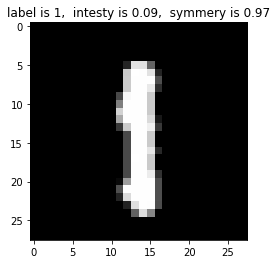

In [21]:
# pick a random item from the training set and visualize it
k = np.random.choice(len(training_images))
# your code goes here 
example_image = training_images[:,k].reshape((28,28))
example_label = training_labels[k]

# calclulate intensity and symmetry
itns = mean_intensity(example_image.reshape(784,1)/255)[0][0]
symm = symmetry(example_image.reshape(784,1)/255)[0][0]

# show the image
plt.imshow(example_image, cmap='gray')
# create the title
plt.title('label is '+str(example_label)+', '\
          ' intesty is '+'{0:.2f}'.format(itns)+', '\
          ' symmery is '+'{0:.2f}'.format(symm) )
plt.show()

Let us convert the labels to take values 0 for not being a 1 and value 1 when the label is the digit 1. Remember that we do this to make the data compatible with our regression model.

In [22]:
# creating y from labels: 1->1 and 5->0
y = np.ones((1,len(training_labels)))
y[:,training_labels == 5] = 0

In [23]:
y.shape

(1, 1000)

Now we preprocess the data and present each sample with its value in our two manually created features. Use the functions we define. Note that since we use numpy in our definitions, we can apply the functions in one go to all of our training data.

In [24]:
X_intensity = mean_intensity(training_images/255)
X_symmetry = symmetry(training_images/255)

In [25]:
# make sure that the shape of the variables match 
# our expectation
print(X_symmetry.shape)
print(X_intensity.shape)

(1, 1000)
(1, 1000)


We put together the input data to our model in a tensor X.

In [26]:
X = np.vstack([X_intensity , X_symmetry])
X.shape

(2, 1000)

Finally, we visualize the position of each sample in the the Euclidean plane using the two features we created for that item.

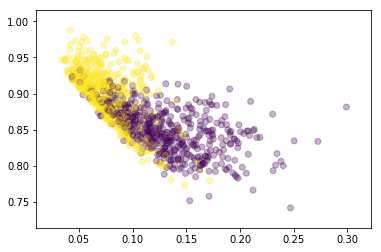

In [27]:
plt.scatter(X[0],X[1],c=y, alpha=0.3)
plt.show()

As you can see there is no clear separation between 1s and 5s using only the two features we created. But majority of the samples are centered around two dense blubs. We can hope that our logistic regression model with a linear desicion boundary will be able to identify majority of the samples but not all of them.

### Problem (Due Date: Wed Oct 11th 6pm)

1. Create another feature that will help with the separation of the 1s and 5s. 
2. When you're done with your feature, visualize it against another feature similar to the previous section.
3. Visualize all three features using a 3D scatter plot.

# Filters and Convolutions

In this section, we briefly go over a particular type of features that turned out to be very important in developement of modern neural netowrks specially in computer vision. 

This image explains the idea of convolution. Assume that you have a matrix $A$, you can convolve it with another (usually smaller) matrix $k$ which is called kernel in the following fashion: you slide the kernel matrix over $A$ and at each location, you store the sum of the element-wise multipications of the kernel with the current location of $A$. You store these values in a new matrix which is the result of the convolution   
![Convolution](https://www.dropbox.com/s/43oivzz1xg9x3v8/kernel_convolution.jpg?raw=1 "Convolution")

To fully understand it. Let us consider a simple example.

$$A=
\left(\begin{array}{cc} 
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 1 & 1 & 1\\
0 & 0 & 0 & 1 & 1 & 1\\
0 & 0 & 0 & 1 & 1 & 1\\
0 & 0 & 0 & 1 & 1 & 1\\
\end{array}\right)$$

$$
K = 
\left(\begin{array}{cc} 
-1 & -1 &\\
1 & 1\\
\end{array}\right)$$

What would be the result of the convolution of $A$ with kernel $K$?

What does this feature represent visually? In other words, is there a feature in $A$ that convolving with $K$ brings it up?

Here we apply this kernel to a few samples from our dataset.

J:\Anaconda\envs\CS6831\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


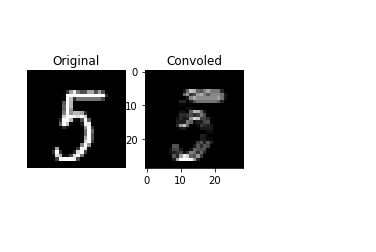

In [28]:
from scipy import signal

# pick a random image from our dataset
k = np.random.choice(len(training_images))
example_image = training_images[:,k].reshape((28,28))/255

# define a kernel
ker = np.array([[ -1, -1],
                [ 1, 1]])

# find the convolution
grad = signal.convolve2d(example_image, ker)

fig, (ax_orig, ax_mag, ax_ang) = plt.subplots(1, 3)

ax_orig.imshow(example_image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()

ax_mag.imshow(np.absolute(grad), cmap='gray')
ax_mag.set_title('Convoled')
ax_ang.set_axis_off()
fig.show()

Our next feature will be a vertical edge mean intesity. Note that, in average, we have more vertical edges for 5s so this can help identifying 1s from 5s. There is a way to write our function is vectorized style but to avoid complexity, we write it using a for loop.

In [29]:
def v_edge(X):
    m = X.shape[1]
    ker = np.array([[ -1, -1],
                    [ 1, 1]])
    mean_ver_edge = np.zeros((1,m))
    for j in range(m):
        image = X[:,j].reshape((28,28))/255
        grad = signal.convolve2d(image, ker)
        mean_ver_edge[:,j] = np.mean(np.absolute(grad))        
    return mean_ver_edge
    

In [30]:
mean_ver_edge = v_edge(training_images/255)
mean_ver_edge.shape

(1, 1000)

We now put together all three features and do the 3D scatter plot using all three features.

In [31]:
X = np.vstack([X_intensity , X_symmetry, mean_ver_edge])

In [32]:
X.shape

(3, 1000)

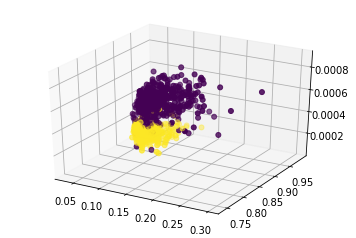

In [33]:
fig = plt.figure()
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(1,1,1, projection='3d')


# the scatter plot
ax.scatter(X[0], X[1], X[2], c=y, s=25)

plt.show()

In [ ]:
# Next Trying horizontal edge followed by vertical edge detector on same image 
#With 3 x3 kernel

In [70]:
def hv_edge(X):
    m = X.shape[1]
    ker_h = np.array([[ +1, +2,+1],[0,0,0],
                    [ -1,-2,-1]])
    ker_v = np.array([[ 1,0,-1],[2,0,-2],
                    [ 1,0,-1]])
    
    mean_hv_edge = np.zeros((1,m))
    for j in range(m):
        image = X[:,j].reshape((28,28))/255
        grad_h = signal.convolve2d(image, ker_h)
        # Computing gradient(vertical) of gradient(horizontal)
        grad_hv = signal.convolve2d(grad_h, ker_v)
        # Computing gradient(horizontal) of gradient(vertical)
        grad_v = signal.convolve2d(image, ker_v)
        grad_vh = signal.convolve2d(grad_v, ker_h)
        
        mean_hv_edge[:,j] = np.mean(np.absolute(grad_hv+grad_vh))
    return mean_hv_edge

In [71]:
mean_hv_edge = hv_edge(training_images/255)
mean_hv_edge.shape

(1, 1000)

In [72]:
X = np.vstack([X_intensity , X_symmetry, mean_hv_edge])
X.shape

(3, 1000)

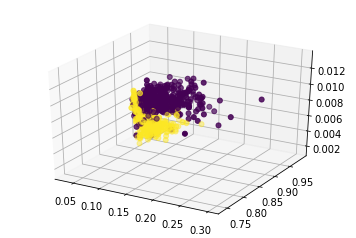

In [73]:
fig = plt.figure()
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(1,1,1, projection='3d')

# the scatter plot
ax.scatter(X[0], X[1], X[2], c=y, s=25)

plt.show()

In [89]:
#Using Sobel operator
def sobel_edge(X):
    m = X.shape[1]
    ker_h = np.array([[ +1, +2,+1],[0,0,0],
                    [ -1,-2,-1]])
    ker_v = np.array([[ 1,0,-1],[2,0,-2],
                    [ 1,0,-1]])
    
    mean_s_edge = np.zeros((1,m))
    for j in range(m):
        image = X[:,j].reshape((28,28))/255
        grad_h = signal.convolve2d(image, ker_h)
        grad_v = signal.convolve2d(image, ker_v)
        phase=np.arctan2(grad_h,grad_v)
        mean_s_edge[:,j] = np.mean(np.absolute(phase))
        #mean_s_edge[:,j] = np.mean(np.absolute(np.sin(phase)*np.cos(phase)))
    return mean_s_edge

In [90]:
mean_s_edge = sobel_edge(training_images/255)
mean_s_edge.shape

(1, 1000)

In [91]:
X = np.vstack([X_intensity , X_symmetry, mean_s_edge])
X.shape

(3, 1000)

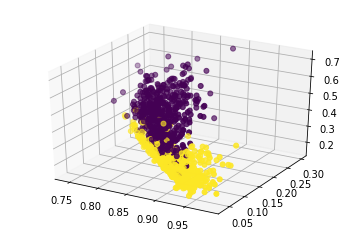

In [92]:
fig = plt.figure()
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(1,1,1, projection='3d')

# the scatter plot
ax.scatter(X[1],X[0], X[2], c=y, s=25)

plt.show()

With such a nice separation between the classes, we can hope that even a simple logistic regression with a linear decision boundary would be able to identify 1s from 5s.

# Step 2: Training

In this step, we will go over training a simple regression as our model.

Remembet that the regression model is defined by the composition of a linear funciton and a sigmoid. So for the input $x^i$ have
$$z^{i} = W^T x^{i} + b$$
$$h(x^i) = \hat{y}^{i} = sigmoid(z^{i})= \frac{1}{1+e^{-z^{i}}}$$
$$h(x^i) = \frac{1}{1+e^{-(W^T x^{i} + b)}}$$

Our model gets an input $X$ and creates a value between 0 and 1 as the probability of the input being the digit 1. Note that the input $X$ is a matrix of dimensions $(d,M)$ and $W$ is a vector of dimensions $(d,1)$ and $b$ is a scalar. Also, note that when you add a scalar to a vector or a matrix, it is added to each element in the matrix.

In [ ]:
def hyp_fun(X,W,b):
    
    # linear combination of inputs
    z = np.dot(W.T,X)+b
    # sigmoid function on top of the linear function
    yhat = np.divide(1,np.array(1+np.exp(-z)))
    
    # we consider .5 as our threshhold
    # yhat>.5 -> 1 and yhat<.5 -> 0
    binary_yhat = np.zeros_like(yhat)
    for i in range(yhat.shape[1]):
        if yhat[0,i]>.5:
            binary_yhat[0,i]=1
            
    return binary_yhat

Remind yourself of the loss function associated with the logistic regression model:

$$ J = \frac{1}{m} \sum - y^{i}  \log(\hat{y}^{i}) - (1-y^{i} )  \log(1-\hat{y}^{i})$$
$$ J = \frac{1}{m} \sum - y^{i}  \log(g(x^i)) - (1-y^{i} )  \log(1-g(x^i))$$

** Exercise.** Find the derivate of the cost function with respect to $W$ and $b$. Your answer should match the derivatives in the next cell.

Next, we need to find the derivatives of the cost function with respect to the model parameters. Remind yourself of how to calculate the derivatives. 

$$ \frac{\partial J}{\partial W} = \frac{1}{m}X(g(X)-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (g(x^i)-y^{i})$$

We are now ready to train the model. Remember that to tune the parameters the model, we need to nudge them in the direction that decreases the error. The direction is given by the gradient, so we have

$$W_{new} = W_{cur} - \lambda \frac{\partial J}{\partial W}$$

$$b_{new} = b_{cur} - \lambda \frac{\partial J}{\partial b}$$

We calculate our accuracy based on the percentage of correct answers we get from our model.

Finally, we initialize our parameters (more about this later). And we go over a for loop to tune our parameters to minimize cost.

In [ ]:
from tqdm import tqdm

dim = X.shape[0]
m = X.shape[1]

costs = []
accs = []

w = np.zeros((dim,1))
b = 0

learning_rate = 0.01

for i in tqdm(range(250000)):
    z = np.dot(w.T,X)+b
    A = np.divide(1,np.array(1+np.exp(-z)))

    cost = (-1./m)*np.sum(y*np.log(A)+(1-y)*np.log((1-A)))
    
    acc = 100 - np.mean(np.abs(hyp_fun(X,w,b) - y)) * 100

    dw = (1./m)*np.dot(X,(A-y).T)
    db = (1./m)*np.sum(A-y)
    
    w = w - learning_rate*dw
    b = b - learning_rate*db
    
    if i % 100 == 0:
        costs.append(cost)
        accs.append(acc)

In [ ]:
# Plot learning curve (with costs)
costs = np.squeeze(costs)
plt.plot(costs)
plt.show()

In [ ]:
# Plot learning curve (with costs)
accs = np.squeeze(accs)
plt.plot(accs)
plt.show()

Here, we go over an extra step to test our method on some handwritten digits written by ourselves. To load and process the images, we need to install the `opencv3` library by running the command
```
conda install -c menpo opencv3 
```

**Excercise.** Compute the accuracy of our model on a test set. Remember that you will need to separate a part of the data including only 1s and 5s and retrain the model on images not in that subset (the model should not see the test data in the training phase). When done with training, compare the predicted label `yhat=hyp_fun(X_test)` with the actual label `y_test` and find the percentage of the correct answers. You answer should be above $70$ percent.